In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
import warnings
 
warnings.filterwarnings('ignore')

In [4]:
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

In [5]:
period = 4096

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1066

1066

In [7]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [8]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002", "ret.4096.004"])
n_signal = len(signal_list)

In [9]:
split_str = "201910"
train_sample = all_dates<split_str
test_sample = all_dates>split_str
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
print(sum(train_sample))
print(sum(test_sample))
format_dates[test_sample][0]

486
580


Timestamp('2019-10-08 00:00:00')

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".004"
#y_signal = "ret."+str(period)

- at first we try using lasso for them together 

In [11]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [12]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape
## (4000, 45)

(4000, 45)

In [13]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl").iloc[:-1,:]
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl").iloc[:-1,:]
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# bu (3999, 49)
# ru (4163, 49)
# v (1755, 49)
# pp (2673, 49)
# l (1936, 49)
# jd (1562, 49)




bu (3999, 49)
ru (4163, 49)
v (1755, 49)
pp (2673, 49)
l (1936, 49)
jd (1562, 49)


In [14]:
#result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))

In [15]:
# pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]

In [16]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [17]:
x_train = train_mat.iloc[:, :n_signal].values
#x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
#fit_coef = np.zeros(n_signal)
#fit_coef[pos] = model.coef_/x_std
fit_coef = model.coef_/x_std
print(fit_coef)

# (16088, 45)
# [-0.          0.          0.         -0.         -0.          0.00663095
#   0.         -0.         -0.         -0.         -0.          0.
#  -0.02034936 -0.01748058  0.         -0.         -0.         -0.
#  -0.         -0.          0.         -0.         -0.          0.
#  -0.          0.         -0.         -0.         -0.          0.
#  -0.         -0.          0.          0.          0.         -0.
#  -0.00174033  0.          0.         -0.          0.          0.00897258
#   0.          0.          0.        ]








(16088, 45)
[-0.          0.          0.         -0.         -0.          0.00663095
  0.         -0.         -0.         -0.         -0.          0.
 -0.02034936 -0.01748058  0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.
 -0.00174033  0.          0.         -0.          0.          0.00897258
  0.          0.          0.        ]


In [18]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])
    
# bu
# price.osci.4096                0.000070
# dbook.range.4096              -0.000082
# range.pos.range.4096          -0.000024
# trade.imb.trend.index.4096    -0.000419
# price.osci.trend.index.4096    0.000145
# dtype: float64
# ru
# price.osci.4096                0.000067
# dbook.range.4096              -0.000031
# range.pos.range.4096          -0.000006
# trade.imb.trend.index.4096    -0.000614
# price.osci.trend.index.4096    0.000165
# dtype: float64
# v
# price.osci.4096                0.000077
# dbook.range.4096              -0.000034
# range.pos.range.4096          -0.000011
# trade.imb.trend.index.4096    -0.000298
# price.osci.trend.index.4096    0.000162
# dtype: float64
# pp
# price.osci.4096                0.000062
# dbook.range.4096              -0.000064
# range.pos.range.4096          -0.000008
# trade.imb.trend.index.4096    -0.000571
# price.osci.trend.index.4096    0.000135
# dtype: float64
# l
# price.osci.4096                0.000061
# dbook.range.4096              -0.000034
# range.pos.range.4096          -0.000008
# trade.imb.trend.index.4096    -0.000312
# price.osci.trend.index.4096    0.000128
# dtype: float64
# jd
# price.osci.4096                0.000078
# dbook.range.4096              -0.000082
# range.pos.range.4096          -0.000020
# trade.imb.trend.index.4096    -0.000632
# price.osci.trend.index.4096    0.000168
# dtype: float64

bu
price.osci.4096                0.000070
dbook.range.4096              -0.000082
range.pos.range.4096          -0.000024
trade.imb.trend.index.4096    -0.000419
price.osci.trend.index.4096    0.000145
dtype: float64
ru
price.osci.4096                0.000067
dbook.range.4096              -0.000031
range.pos.range.4096          -0.000006
trade.imb.trend.index.4096    -0.000614
price.osci.trend.index.4096    0.000165
dtype: float64
v
price.osci.4096                0.000077
dbook.range.4096              -0.000034
range.pos.range.4096          -0.000011
trade.imb.trend.index.4096    -0.000298
price.osci.trend.index.4096    0.000162
dtype: float64
pp
price.osci.4096                0.000062
dbook.range.4096              -0.000064
range.pos.range.4096          -0.000008
trade.imb.trend.index.4096    -0.000571
price.osci.trend.index.4096    0.000135
dtype: float64
l
price.osci.4096                0.000061
dbook.range.4096              -0.000034
range.pos.range.4096          -0.000008
trade.i

In [19]:
SAVE_PATH = "e:/intern"
#save(coef_list, SAVE_PATH+"/finance.lasso.pkl")
save(coef_list, SAVE_PATH+"/energy.lasso.pkl")

In [20]:
#coef_list = load(SAVE_PATH+"/finance.lasso.pkl")
coef_list = load(SAVE_PATH+"/energy.lasso.pkl")

In [21]:
strat = "overall.energy.lasso."+str(period)
   
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [22]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# bu
# ru
# v
# pp
# l
# jd
# Wall time: 56min 1s

bu
ru
v
pp
l
jd
Wall time: 56min 1s


In [23]:
%%time
for product in product_list:
    print(product)
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

# bu
# ru
# v
# pp
# l
# jd
# Wall time: 5min 47s



bu
ru
v
pp
l
jd
Wall time: 5min 47s


In [27]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("overall.energy.lasso", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 11min 15s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 11min 15s


bu train sharpe  0.6011867350266192 test sharpe  -0.1631903471995629
v train sharpe  0.7502234166946331 test sharpe  -0.7470389513497625
pp train sharpe  0.5659746919019489 test sharpe  0.7050143506938111
jd train sharpe  0.9873835892951233 test sharpe  1.345749107960923
train sharpe:  1.1864715941142205 test sharpe:  0.30503552389627475


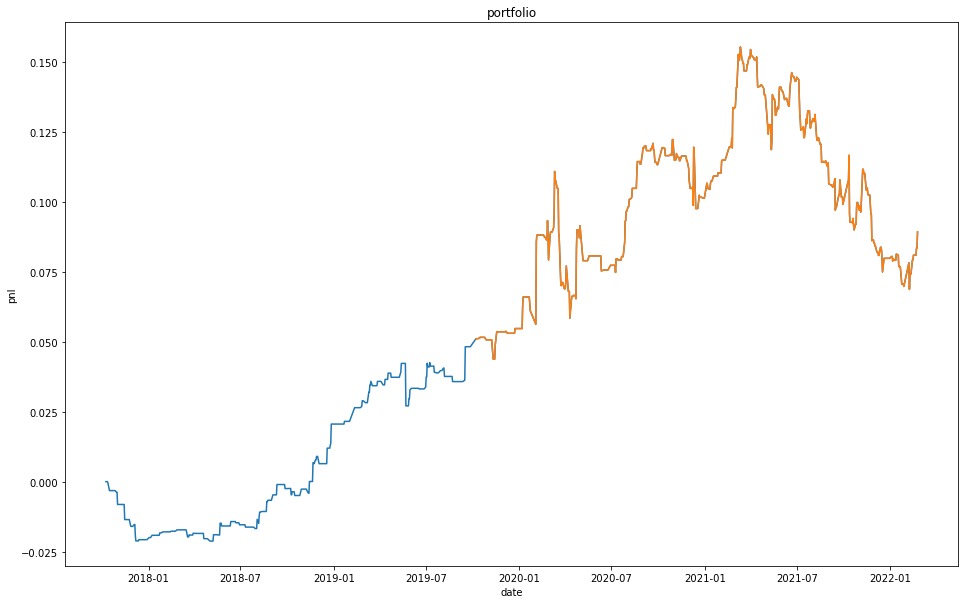

In [28]:
i = 0
strat = "overall.energy.lasso.4096"
test_sample = all_dates>split_str
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)==0:
        continue
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# bu train sharpe  0.6011867350266192 test sharpe  -0.1631903471995629
# v train sharpe  0.7502234166946331 test sharpe  -0.7470389513497625
# pp train sharpe  0.5659746919019489 test sharpe  0.7050143506938111
# jd train sharpe  0.9873835892951233 test sharpe  1.345749107960923
# train sharpe:  1.1864715941142205 test sharpe:  0.30503552389627475







- we can see that the result is much better than before
- so we can use this method for rolling models
- However, using the previous method may be too slow
- we calcualte the predictions values of each product using 26 mintues, and other time add up together would be 30 mintues
- if we are rolling on a monthly basis
- from 201801 to 201908 there are 20 months
- so it may use 10 hours for the rolling

- rolling model

- at first we need to know how many ticks every day

In [29]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

- at first we can try a not so intensive method
- we can get the starting day for train

In [30]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

- at first we can try a not so intensive method
- we can get the starting day for train

In [31]:
from sklearn.preprocessing import StandardScaler

- now we generate prediction values for next 22 days

- now we can combien all these and get a function for rolling
- we can also use calendar month rather than 22 days

In [32]:
month = np.array([file[:6] for file in all_dates])

In [33]:
month_len = np.unique(month, return_counts=True)
month_len

# (array(['201710', '201711', '201712', '201801', '201802', '201803',
#         '201804', '201805', '201806', '201807', '201808', '201809',
#         '201810', '201811', '201812', '201901', '201902', '201903',
#         '201904', '201905', '201906', '201907', '201908', '201909',
#         '201910', '201911', '201912', '202001', '202002', '202003',
#         '202004', '202005', '202006', '202007', '202008', '202009',
#         '202010', '202011', '202012', '202101', '202102', '202103',
#         '202104', '202105', '202106', '202107', '202108', '202109',
#         '202110', '202111', '202112', '202201', '202202'], dtype='<U6'),
#  array([17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15,
#         21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 21, 18, 20, 23,
#         21, 22, 16, 21, 23, 20, 15, 23, 21, 18, 21, 22, 22, 20, 16, 22, 23,
#         19, 14], dtype=int64))

(array(['201710', '201711', '201712', '201801', '201802', '201803',
        '201804', '201805', '201806', '201807', '201808', '201809',
        '201810', '201811', '201812', '201901', '201902', '201903',
        '201904', '201905', '201906', '201907', '201908', '201909',
        '201910', '201911', '201912', '202001', '202002', '202003',
        '202004', '202005', '202006', '202007', '202008', '202009',
        '202010', '202011', '202012', '202101', '202102', '202103',
        '202104', '202105', '202106', '202107', '202108', '202109',
        '202110', '202111', '202112', '202201', '202202'], dtype='<U6'),
 array([17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15,
        21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 21, 18, 20, 23,
        21, 22, 16, 21, 23, 20, 15, 23, 21, 18, 21, 22, 22, 20, 16, 22, 23,
        19, 14], dtype=int64))

In [34]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        #print(np.shape(x_train))
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    train_mat = pd.DataFrame(train_mat, columns=signal_list)
    train_mat[y_signal] = y_train
    #result = forward_selected(train_mat, y_signal)
    #x_train = train_mat[result["chosen.signals"]]
    x_train = train_mat.iloc[:,:n_signal]
    #pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std ## transform to the value before second normaliztion
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    #print(fit_coef)
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [35]:
test_range = np.where(month_len[0] >= split_str )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < split_str)-1
cum_month_len = np.cumsum(month_len[1])

# ['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
#  '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
#  '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
#  '202110' '202111' '202112' '202201' '202202']




['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
 '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
 '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
 '202110' '202111' '202112' '202201' '202202']


In [36]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.energy.lasso.4096" ## with double normalization
y_signal = "ret.4096.004"
#y_signal = "ret.4096"
start_month = 0
end_month = sum(month_len[0] < split_str)-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          [], product_list, period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 24 201910
# 25 201911
# 26 201912
# 27 202001
# 28 202002
# 29 202003
# 30 202004
# 31 202005
# 32 202006
# 33 202007
# 34 202008
# 35 202009
# 36 202010
# 37 202011
# 38 202012
# 39 202101
# 40 202102
# 41 202103
# 42 202104
# 43 202105
# 44 202106
# 45 202107
# 46 202108
# 47 202109
# 48 202110
# 49 202111
# 50 202112
# 51 202201
# 52 202202
# Wall time: 3min 59s


24 201910
25 201911
26 201912
27 202001
28 202002
29 202003
30 202004
31 202005
32 202006
33 202007
34 202008
35 202009
36 202010
37 202011
38 202012
39 202101
40 202102
41 202103
42 202104
43 202105
44 202106
45 202107
46 202108
47 202109
48 202110
49 202111
50 202112
51 202201
52 202202
Wall time: 3min 59s


- Then we can generate prediction values of each model

In [37]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] < split_str)-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
        parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 24 201910
# 25 201911
# 26 201912
# 27 202001
# 28 202002
# 29 202003
# 30 202004
# 31 202005
# 32 202006
# 33 202007
# 34 202008
# 35 202009
# 36 202010
# 37 202011
# 38 202012
# 39 202101
# 40 202102
# 41 202103
# 42 202104
# 43 202105
# 44 202106
# 45 202107
# 46 202108
# 47 202109
# 48 202110
# 49 202111
# 50 202112
# 51 202201
# 52 202202
# Wall time: 13h 27min 55s

24 201910
25 201911
26 201912
27 202001
28 202002
29 202003
30 202004
31 202005
32 202006
33 202007
34 202008
35 202009
36 202010
37 202011
38 202012
39 202101
40 202102
41 202103
42 202104
43 202105
44 202106
45 202107
46 202108
47 202109
48 202110
49 202111
50 202112
51 202201
52 202202
Wall time: 13h 27min 55s


In [38]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.energy.lasso.4096"
start_month = 0
end_month = sum(month_len[0] < split_str)-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    ## we only generte distribution on training set, not on test set
    for product in product_list:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201910 20171009.pkl 20190930.pkl
# 201911 20171101.pkl 20191031.pkl
# 201912 20171201.pkl 20191129.pkl
# 202001 20180102.pkl 20191231.pkl
# 202002 20180201.pkl 20200123.pkl
# 202003 20180301.pkl 20200228.pkl
# 202004 20180402.pkl 20200331.pkl
# 202005 20180502.pkl 20200430.pkl
# 202006 20180601.pkl 20200529.pkl
# 202007 20180702.pkl 20200630.pkl
# 202008 20180801.pkl 20200731.pkl
# 202009 20180903.pkl 20200831.pkl
# 202010 20181008.pkl 20200930.pkl
# 202011 20181101.pkl 20201030.pkl
# 202012 20181203.pkl 20201130.pkl
# 202101 20190102.pkl 20201231.pkl
# 202102 20190201.pkl 20210129.pkl
# 202103 20190301.pkl 20210226.pkl
# 202104 20190401.pkl 20210331.pkl
# 202105 20190506.pkl 20210430.pkl
# 202106 20190603.pkl 20210531.pkl
# 202107 20190701.pkl 20210630.pkl
# 202108 20190801.pkl 20210730.pkl
# 202109 20190902.pkl 20210831.pkl
# 202110 20191008.pkl 20210930.pkl
# 202111 20191101.pkl 20211029.pkl
# 202112 20191202.pkl 20211130.pkl
# 202201 20200102.pkl 20211231.pkl
# 202202 20200203.pkl 20220128.pkl
# Wall time: 54min 59s


201910 20171009.pkl 20190930.pkl
201911 20171101.pkl 20191031.pkl
201912 20171201.pkl 20191129.pkl
202001 20180102.pkl 20191231.pkl
202002 20180201.pkl 20200123.pkl
202003 20180301.pkl 20200228.pkl
202004 20180402.pkl 20200331.pkl
202005 20180502.pkl 20200430.pkl
202006 20180601.pkl 20200529.pkl
202007 20180702.pkl 20200630.pkl
202008 20180801.pkl 20200731.pkl
202009 20180903.pkl 20200831.pkl
202010 20181008.pkl 20200930.pkl
202011 20181101.pkl 20201030.pkl
202012 20181203.pkl 20201130.pkl
202101 20190102.pkl 20201231.pkl
202102 20190201.pkl 20210129.pkl
202103 20190301.pkl 20210226.pkl
202104 20190401.pkl 20210331.pkl
202105 20190506.pkl 20210430.pkl
202106 20190603.pkl 20210531.pkl
202107 20190701.pkl 20210630.pkl
202108 20190801.pkl 20210730.pkl
202109 20190902.pkl 20210831.pkl
202110 20191008.pkl 20210930.pkl
202111 20191101.pkl 20211029.pkl
202112 20191202.pkl 20211130.pkl
202201 20200102.pkl 20211231.pkl
202202 20200203.pkl 20220128.pkl
Wall time: 54min 59s


In [39]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", split_str="201804",
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < split_str)-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [40]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.energy.lasso.4096"
for product in product_list:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=0.01)

# bu 24 roll.energy.lasso.4096.201910
# bu 25 roll.energy.lasso.4096.201911
# bu 26 roll.energy.lasso.4096.201912
# bu 27 roll.energy.lasso.4096.202001
# bu 28 roll.energy.lasso.4096.202002
# bu 29 roll.energy.lasso.4096.202003
# bu 30 roll.energy.lasso.4096.202004
# bu 31 roll.energy.lasso.4096.202005
# bu 32 roll.energy.lasso.4096.202006
# bu 33 roll.energy.lasso.4096.202007
# bu 34 roll.energy.lasso.4096.202008
# bu 35 roll.energy.lasso.4096.202009
# bu 36 roll.energy.lasso.4096.202010
# bu 37 roll.energy.lasso.4096.202011
# bu 38 roll.energy.lasso.4096.202012
# bu 39 roll.energy.lasso.4096.202101
# bu 40 roll.energy.lasso.4096.202102
# bu 41 roll.energy.lasso.4096.202103
# bu 42 roll.energy.lasso.4096.202104
# bu 43 roll.energy.lasso.4096.202105
# bu 44 roll.energy.lasso.4096.202106
# bu 45 roll.energy.lasso.4096.202107
# bu 46 roll.energy.lasso.4096.202108
# bu 47 roll.energy.lasso.4096.202109
# bu 48 roll.energy.lasso.4096.202110
# bu 49 roll.energy.lasso.4096.202111
# bu 50 roll.energy.lasso.4096.202112
# bu 51 roll.energy.lasso.4096.202201
# bu 52 roll.energy.lasso.4096.202202
# ru 24 roll.energy.lasso.4096.201910
# ru 25 roll.energy.lasso.4096.201911
# ru 26 roll.energy.lasso.4096.201912
# ru 27 roll.energy.lasso.4096.202001
# ru 28 roll.energy.lasso.4096.202002
# ru 29 roll.energy.lasso.4096.202003
# ru 30 roll.energy.lasso.4096.202004
# ru 31 roll.energy.lasso.4096.202005
# ru 32 roll.energy.lasso.4096.202006
# ru 33 roll.energy.lasso.4096.202007
# ru 34 roll.energy.lasso.4096.202008
# ru 35 roll.energy.lasso.4096.202009
# ru 36 roll.energy.lasso.4096.202010
# ru 37 roll.energy.lasso.4096.202011
# ru 38 roll.energy.lasso.4096.202012
# ru 39 roll.energy.lasso.4096.202101
# ru 40 roll.energy.lasso.4096.202102
# ru 41 roll.energy.lasso.4096.202103
# ru 42 roll.energy.lasso.4096.202104
# ru 43 roll.energy.lasso.4096.202105
# ru 44 roll.energy.lasso.4096.202106
# ru 45 roll.energy.lasso.4096.202107
# ru 46 roll.energy.lasso.4096.202108
# ru 47 roll.energy.lasso.4096.202109
# ru 48 roll.energy.lasso.4096.202110
# ru 49 roll.energy.lasso.4096.202111
# ru 50 roll.energy.lasso.4096.202112
# ru 51 roll.energy.lasso.4096.202201
# ru 52 roll.energy.lasso.4096.202202
# v 24 roll.energy.lasso.4096.201910
# v 25 roll.energy.lasso.4096.201911
# v 26 roll.energy.lasso.4096.201912
# v 27 roll.energy.lasso.4096.202001
# v 28 roll.energy.lasso.4096.202002
# v 29 roll.energy.lasso.4096.202003
# v 30 roll.energy.lasso.4096.202004
# v 31 roll.energy.lasso.4096.202005
# v 32 roll.energy.lasso.4096.202006
# v 33 roll.energy.lasso.4096.202007
# v 34 roll.energy.lasso.4096.202008
# v 35 roll.energy.lasso.4096.202009
# v 36 roll.energy.lasso.4096.202010
# v 37 roll.energy.lasso.4096.202011
# v 38 roll.energy.lasso.4096.202012
# v 39 roll.energy.lasso.4096.202101
# v 40 roll.energy.lasso.4096.202102
# v 41 roll.energy.lasso.4096.202103
# v 42 roll.energy.lasso.4096.202104
# v 43 roll.energy.lasso.4096.202105
# v 44 roll.energy.lasso.4096.202106
# v 45 roll.energy.lasso.4096.202107
# v 46 roll.energy.lasso.4096.202108
# v 47 roll.energy.lasso.4096.202109
# v 48 roll.energy.lasso.4096.202110
# v 49 roll.energy.lasso.4096.202111
# v 50 roll.energy.lasso.4096.202112
# v 51 roll.energy.lasso.4096.202201
# v 52 roll.energy.lasso.4096.202202
# pp 24 roll.energy.lasso.4096.201910
# pp 25 roll.energy.lasso.4096.201911
# pp 26 roll.energy.lasso.4096.201912
# pp 27 roll.energy.lasso.4096.202001
# pp 28 roll.energy.lasso.4096.202002
# pp 29 roll.energy.lasso.4096.202003
# pp 30 roll.energy.lasso.4096.202004
# pp 31 roll.energy.lasso.4096.202005
# pp 32 roll.energy.lasso.4096.202006
# pp 33 roll.energy.lasso.4096.202007
# pp 34 roll.energy.lasso.4096.202008
# pp 35 roll.energy.lasso.4096.202009
# pp 36 roll.energy.lasso.4096.202010
# pp 37 roll.energy.lasso.4096.202011
# pp 38 roll.energy.lasso.4096.202012
# pp 39 roll.energy.lasso.4096.202101
# pp 40 roll.energy.lasso.4096.202102
# pp 41 roll.energy.lasso.4096.202103
# pp 42 roll.energy.lasso.4096.202104
# pp 43 roll.energy.lasso.4096.202105
# pp 44 roll.energy.lasso.4096.202106
# pp 45 roll.energy.lasso.4096.202107
# pp 46 roll.energy.lasso.4096.202108
# pp 47 roll.energy.lasso.4096.202109
# pp 48 roll.energy.lasso.4096.202110
# pp 49 roll.energy.lasso.4096.202111
# pp 50 roll.energy.lasso.4096.202112
# pp 51 roll.energy.lasso.4096.202201
# pp 52 roll.energy.lasso.4096.202202
# l 24 roll.energy.lasso.4096.201910
# l 25 roll.energy.lasso.4096.201911
# l 26 roll.energy.lasso.4096.201912
# l 27 roll.energy.lasso.4096.202001
# l 28 roll.energy.lasso.4096.202002
# l 29 roll.energy.lasso.4096.202003
# l 30 roll.energy.lasso.4096.202004
# l 31 roll.energy.lasso.4096.202005
# l 32 roll.energy.lasso.4096.202006
# l 33 roll.energy.lasso.4096.202007
# l 34 roll.energy.lasso.4096.202008
# l 35 roll.energy.lasso.4096.202009
# l 36 roll.energy.lasso.4096.202010
# l 37 roll.energy.lasso.4096.202011
# l 38 roll.energy.lasso.4096.202012
# l 39 roll.energy.lasso.4096.202101
# l 40 roll.energy.lasso.4096.202102
# l 41 roll.energy.lasso.4096.202103
# l 42 roll.energy.lasso.4096.202104
# l 43 roll.energy.lasso.4096.202105
# l 44 roll.energy.lasso.4096.202106
# l 45 roll.energy.lasso.4096.202107
# l 46 roll.energy.lasso.4096.202108
# l 47 roll.energy.lasso.4096.202109
# l 48 roll.energy.lasso.4096.202110
# l 49 roll.energy.lasso.4096.202111
# l 50 roll.energy.lasso.4096.202112
# l 51 roll.energy.lasso.4096.202201
# l 52 roll.energy.lasso.4096.202202
# jd 24 roll.energy.lasso.4096.201910
# jd 25 roll.energy.lasso.4096.201911
# jd 26 roll.energy.lasso.4096.201912
# jd 27 roll.energy.lasso.4096.202001
# jd 28 roll.energy.lasso.4096.202002
# jd 29 roll.energy.lasso.4096.202003
# jd 30 roll.energy.lasso.4096.202004
# jd 31 roll.energy.lasso.4096.202005
# jd 32 roll.energy.lasso.4096.202006
# jd 33 roll.energy.lasso.4096.202007
# jd 34 roll.energy.lasso.4096.202008
# jd 35 roll.energy.lasso.4096.202009
# jd 36 roll.energy.lasso.4096.202010
# jd 37 roll.energy.lasso.4096.202011
# jd 38 roll.energy.lasso.4096.202012
# jd 39 roll.energy.lasso.4096.202101
# jd 40 roll.energy.lasso.4096.202102
# jd 41 roll.energy.lasso.4096.202103
# jd 42 roll.energy.lasso.4096.202104
# jd 43 roll.energy.lasso.4096.202105
# jd 44 roll.energy.lasso.4096.202106
# jd 45 roll.energy.lasso.4096.202107
# jd 46 roll.energy.lasso.4096.202108
# jd 47 roll.energy.lasso.4096.202109
# jd 48 roll.energy.lasso.4096.202110
# jd 49 roll.energy.lasso.4096.202111
# jd 50 roll.energy.lasso.4096.202112
# jd 51 roll.energy.lasso.4096.202201
# jd 52 roll.energy.lasso.4096.202202
# Wall time: 1h 38min 11s


bu 24 roll.energy.lasso.4096.201910
bu 25 roll.energy.lasso.4096.201911
bu 26 roll.energy.lasso.4096.201912
bu 27 roll.energy.lasso.4096.202001
bu 28 roll.energy.lasso.4096.202002
bu 29 roll.energy.lasso.4096.202003
bu 30 roll.energy.lasso.4096.202004
bu 31 roll.energy.lasso.4096.202005
bu 32 roll.energy.lasso.4096.202006
bu 33 roll.energy.lasso.4096.202007
bu 34 roll.energy.lasso.4096.202008
bu 35 roll.energy.lasso.4096.202009
bu 36 roll.energy.lasso.4096.202010
bu 37 roll.energy.lasso.4096.202011
bu 38 roll.energy.lasso.4096.202012
bu 39 roll.energy.lasso.4096.202101
bu 40 roll.energy.lasso.4096.202102
bu 41 roll.energy.lasso.4096.202103
bu 42 roll.energy.lasso.4096.202104
bu 43 roll.energy.lasso.4096.202105
bu 44 roll.energy.lasso.4096.202106
bu 45 roll.energy.lasso.4096.202107
bu 46 roll.energy.lasso.4096.202108
bu 47 roll.energy.lasso.4096.202109
bu 48 roll.energy.lasso.4096.202110
bu 49 roll.energy.lasso.4096.202111
bu 50 roll.energy.lasso.4096.202112
bu 51 roll.energy.lasso.4096

sharpe  1.6180844969120685


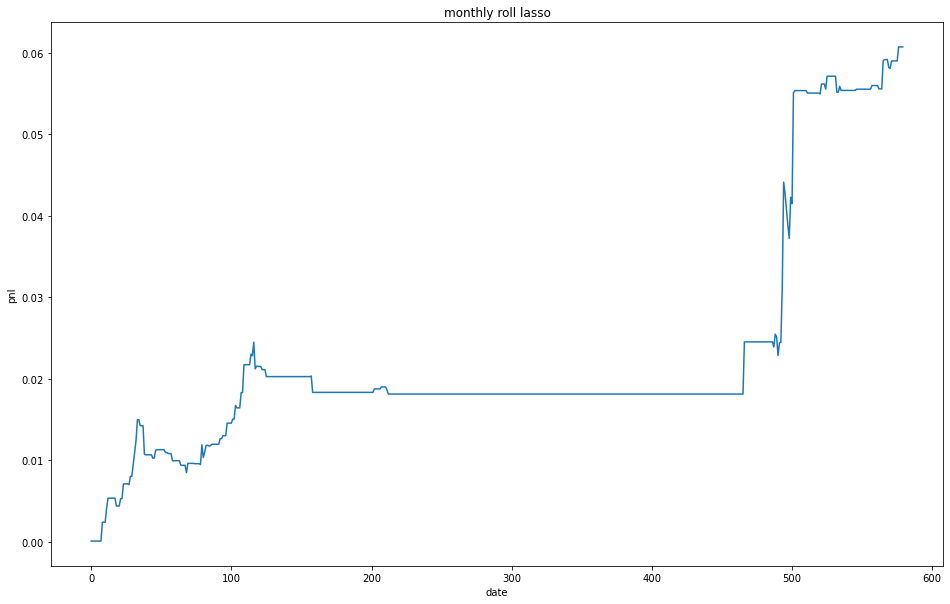

In [41]:
n_product = len(product_list)
save_path = "signal result atr"
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.energy.lasso.4096"
start_month = 0
min_pnl = 2
min_num = 10
end_month = sum(month_len[0] < "201804")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #print(len(avg_test_pnl_mean)==len(avg_test_pnl))
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    #print(all_pnl)
    #print(len(all_pnl), len(avg_test_pnl))
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot( all_pnl.cumsum());
#plt.plot(all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

# sharpe  1.6180844969120685




- result is good